In [524]:
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers

In [724]:
input_dir = "./road/training/image_2/"
target_dir = "./road/training/gt_image_2/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".png")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [725]:
num_image_files = int(len(os.listdir(input_dir)))
print(f"Number of Training Examples: {num_image_files}")

num_mask_files = int(len(os.listdir(target_dir)))
print(f"Number of Training Examples: {num_mask_files}")

Number of Training Examples: 289
Number of Training Examples: 289


In [726]:
img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size))
    img = img.astype("uint8")
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (3,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

print(input_imgs.shape)
print(targets.shape)

(289, 128, 128, 3)
(289, 128, 128, 3)


In [727]:
# 모든 픽셀을 하나의 목록으로 통합
all_pixels = targets.reshape(-1, 3)

# 각 픽셀의 고유한 RGB 값을 찾기
unique_rgb_values = np.unique(all_pixels, axis=0)

print(unique_rgb_values)

[[  0   0   0]
 [  0   0 255]
 [255   0   0]
 [255   0 255]]


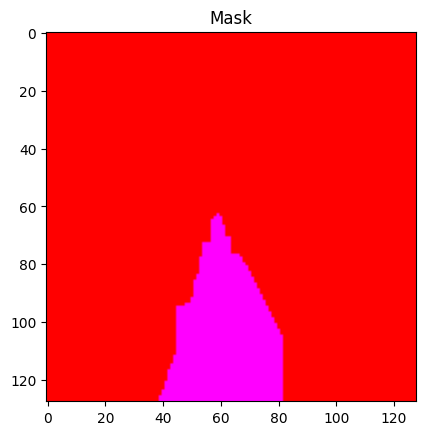

In [728]:
plt.imshow(targets[0]/255.)
plt.title(f'Mask')
plt.show()

In [729]:
# [255, 0, 255]에 해당하는 픽셀을 찾습니다.
road_mask = np.all(targets == [255, 0, 255], axis=-1)

binary_road_mask = road_mask.astype("uint8")
binary_road_mask = binary_road_mask[..., np.newaxis]

binary_road_mask.shape

(289, 128, 128, 1)

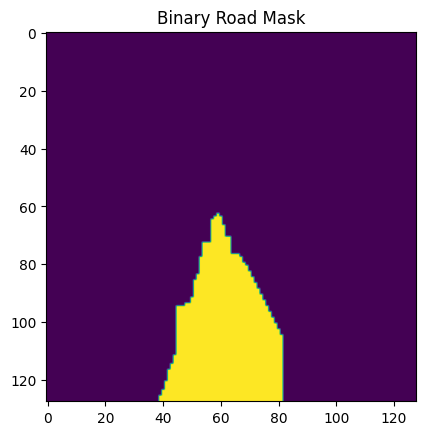

In [730]:
plt.imshow(binary_road_mask[0]/255.)
plt.title('Binary Road Mask')
plt.show()

In [731]:
num_val_samples = 70

input_imgs = input_imgs / 255.

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = binary_road_mask[:-num_val_samples]
test_input_imgs = input_imgs[-num_val_samples:]
test_targets = binary_road_mask[-num_val_samples:]

In [732]:
np.save('./data/train_input_imgs.npy', train_input_imgs)
np.save('./data/train_targets.npy', train_targets)
np.save('./data/test_input_imgs.npy', test_input_imgs)
np.save('./data/test_targets.npy', test_targets)

In [733]:
train_input_imgs = np.load('./data/train_input_imgs.npy')
train_targets = np.load('./data/train_targets.npy')
test_input_imgs = np.load('./data/test_input_imgs.npy')
test_targets = np.load('./data/test_targets.npy')

In [734]:
print(train_input_imgs.shape)
print(train_targets.shape)

(219, 128, 128, 3)
(219, 128, 128, 1)


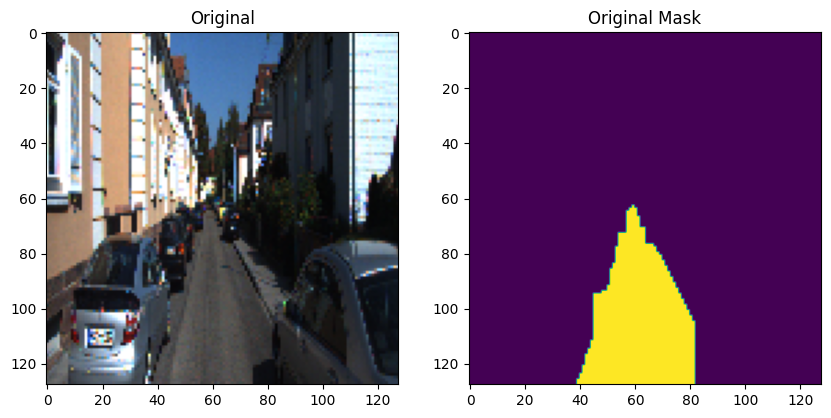

In [735]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(train_input_imgs[0])
ax[0].set_title("Original")

ax[1].imshow(train_targets[0]/255.)
ax[1].set_title("Original Mask")

plt.show()

In [736]:
import albumentations as A
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [737]:
train_input_imgs = train_input_imgs.astype(np.float32)
train_targets = train_targets.astype(np.float32)

In [738]:
aug_test=augmentation_pipeline(image=train_input_imgs[0], mask=train_targets[0])
aug_image_example=aug_test["image"]
aug_mask_example=aug_test["mask"]

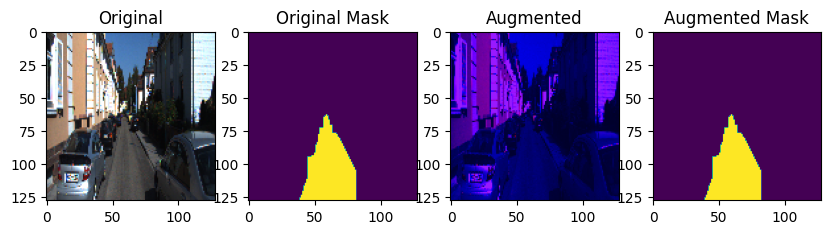

In [739]:
fig, ax = plt.subplots(1, 4, figsize=(10, 7))
ax[0].imshow(train_input_imgs[0])
ax[0].set_title("Original")

ax[1].imshow(train_targets[0])
ax[1].set_title("Original Mask")

ax[2].imshow(aug_image_example)
ax[2].set_title("Augmented")

ax[3].imshow(aug_mask_example)
ax[3].set_title("Augmented Mask")

plt.show()

In [741]:
random.seed(42)  # Fixing the random seed once
np.random.seed(42)

NewIMGS = 10  # Number of augmented images to generate per original image
augmented_images = []
augmented_masks = []

for i in range(len(train_input_imgs)):
    image = train_input_imgs[i]
    mask = train_targets[i]
    
    for j in range(NewIMGS):
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        augmented_images.append(augmented["image"])
        augmented_masks.append(augmented["mask"])

In [742]:
augmented_images = np.array(augmented_images)
np.save('./data/augmented_images.npy', augmented_images)
augmented_images.shape

(2190, 128, 128, 3)

In [743]:
augmented_masks = np.array(augmented_masks)
np.save('./data/augmented_masks.npy', augmented_masks)
augmented_masks.shape

(2190, 128, 128, 1)

In [744]:
augmented_images = np.load('./data/augmented_images.npy')
augmented_masks = np.load('./data/augmented_masks.npy')

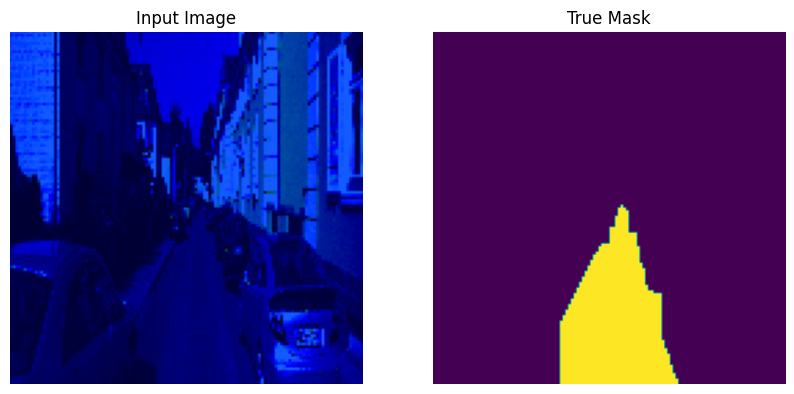

In [745]:
def display_sample(display_list):
    plt.figure(figsize = (10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()
    
display_sample([augmented_images[0], augmented_masks[0]/255.])

In [747]:
# Shuffle the indices
shuffled_indices = np.random.permutation(len(augmented_images))

# Use the shuffled indices to shuffle both arrays
shuffled_data = augmented_images[shuffled_indices]
shuffled_masks = augmented_masks[shuffled_indices]

In [748]:
#train_validation split
train_set_size = int(len(shuffled_data)*0.8)

X_train=shuffled_data[:train_set_size]
y_train=shuffled_masks[:train_set_size]
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:]
y_val=shuffled_masks[train_set_size:]
print(f'validation set size {X_val.shape}')

training set size (1752, 128, 128, 3)
validation set size (438, 128, 128, 3)


In [749]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    #x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=(128, 128), num_classes=1)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 conv2d_57 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 256)       590

### Train Base Segmentation Model

In [750]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/road_segmentation_base.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(X_train, y_train,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/50
28/28 [==============================] - 82s 3s/step - loss: 0.5284 - val_loss: 0.4628
Epoch 2/50
28/28 [==============================] - 80s 3s/step - loss: 0.4689 - val_loss: 0.4574
Epoch 3/50
28/28 [==============================] - 82s 3s/step - loss: 0.4099 - val_loss: 0.3257
Epoch 4/50
28/28 [==============================] - 79s 3s/step - loss: 0.3630 - val_loss: 0.3248
Epoch 5/50
28/28 [==============================] - 79s 3s/step - loss: 0.2986 - val_loss: 0.3433
Epoch 6/50
28/28 [==============================] - 82s 3s/step - loss: 0.2889 - val_loss: 0.2625
Epoch 7/50
28/28 [==============================] - 77s 3s/step - loss: 0.2651 - val_loss: 0.2798
Epoch 8/50
28/28 [==============================] - 80s 3s/step - loss: 0.2601 - val_loss: 0.2726
Epoch 9/50
28/28 [==============================] - 81s 3s/step - loss: 0.2517 - val_loss: 0.3573
Epoch 10/50
28/28 [==============================] - 79s 3s/step - loss: 0.2459 - val_loss: 0.2167
Epoch 11/50
28/28 [

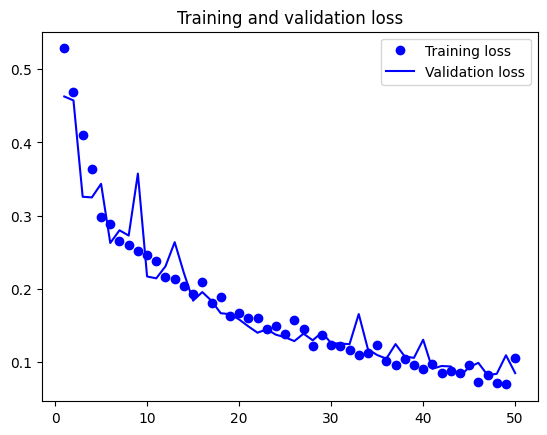

In [751]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [752]:
model = keras.models.load_model("./models/road_segmentation_base.keras")

In [871]:
# choosing a random test image
i = 27
test_image = test_input_imgs[i]
ground_truth_mask = (test_targets[i])

In [872]:
mask_pred = model.predict(np.expand_dims(test_image, 0))[0]
mask_pred.shape

1/1 [==============================] - 0s 51ms/step


(128, 128, 1)

In [873]:
binary_predictions = (mask_pred > 0.5).astype(np.uint8)
print(binary_predictions.shape)
print(ground_truth_mask.shape)


(128, 128, 1)
(128, 128, 1)


In [874]:
# print the predicted and ground truth classification label
print(np.unique(binary_predictions))
print(np.unique(ground_truth_mask))

[0 1]
[0 1]


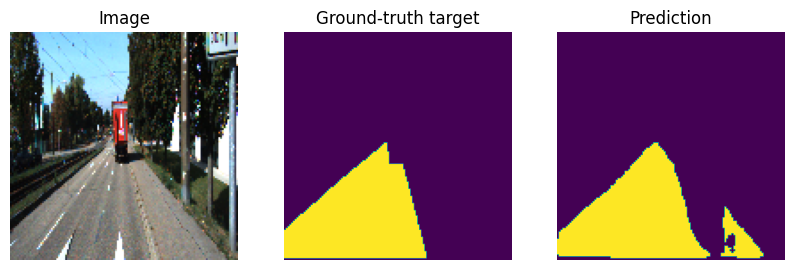

In [875]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(binary_predictions)

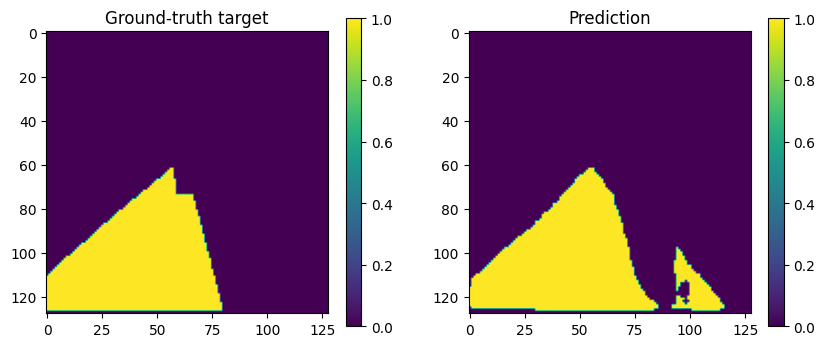

In [877]:
# show a color legend
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Ground-truth target")
plt.imshow(ground_truth_mask)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(binary_predictions)
plt.colorbar()

In [878]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
iou_calculator = MeanIoU(num_classes=n_classes)

iou_calculator.update_state(ground_truth_mask, binary_predictions)
print("Mean IoU =", iou_calculator.result().numpy())


Mean IoU = 0.9024512


Fine-tuning

Reference: https://www.kaggle.com/code/rajkumarl/get-started-with-semantic-segmentation

In [879]:
conv_base_1  = keras.applications.DenseNet121(
    weights="imagenet",
    include_top=False)

conv_base_1.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, None, None,   0          ['input_20[0][0]']               
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_10[0][0]']      
                                64)                                                     

In [844]:
def get_model_2(img_size, num_classes):
    base = keras.applications.DenseNet121(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False  # Freeze the base model

    inputs = keras.Input(shape=img_size + (3,))
    x = base(inputs, training=False)  # Use base in inference mode

    # Start transposed convolutions
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same", strides=2)(x)  # 8x8
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)  # 16x16
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)  # 32x32
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)   # 64x64
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same", strides=2)(x)   # 128x128

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

img_size = (128, 128)
model_2 = get_model_2(img_size=img_size, num_classes=1)
model_2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 conv2d_transpose_63 (Conv2D  (None, 8, 8, 512)        4719104   
 Transpose)                                                      
                                                                 
 conv2d_transpose_64 (Conv2D  (None, 16, 16, 256)      1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_65 (Conv2D  (None, 32, 32, 128)      295040    
 Transpose)                                                      
                                                          

In [845]:
model_2.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks_2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/dense121_finetune.keras",
        save_best_only=True,
        monitor="val_loss")
]

history2 = model_2.fit(X_train, y_train,
                    epochs=30,
                    callbacks=callbacks_2,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/30
28/28 [==============================] - 64s 2s/step - loss: 0.4612 - val_loss: 0.2899
Epoch 2/30
28/28 [==============================] - 54s 2s/step - loss: 0.2716 - val_loss: 0.2553
Epoch 3/30
28/28 [==============================] - 54s 2s/step - loss: 0.2430 - val_loss: 0.2443
Epoch 4/30
28/28 [==============================] - 54s 2s/step - loss: 0.2297 - val_loss: 0.2143
Epoch 5/30
28/28 [==============================] - 55s 2s/step - loss: 0.2047 - val_loss: 0.2300
Epoch 6/30
28/28 [==============================] - 54s 2s/step - loss: 0.1886 - val_loss: 0.1625
Epoch 7/30
28/28 [==============================] - 54s 2s/step - loss: 0.1721 - val_loss: 0.1826
Epoch 8/30
28/28 [==============================] - 54s 2s/step - loss: 0.1676 - val_loss: 0.2003
Epoch 9/30
28/28 [==============================] - 53s 2s/step - loss: 0.1549 - val_loss: 0.1713
Epoch 10/30
28/28 [==============================] - 54s 2s/step - loss: 0.1504 - val_loss: 0.1927
Epoch 11/30
28/28 [

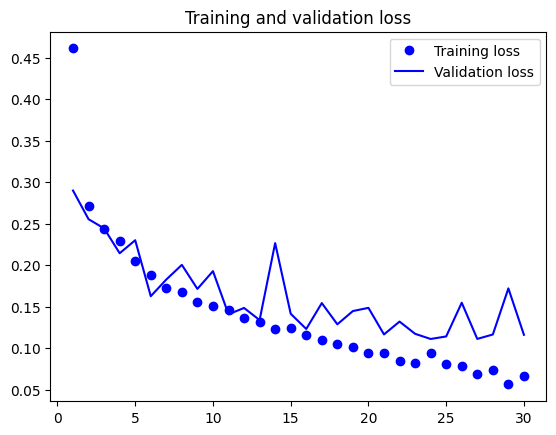

In [858]:
epochs = range(1, len(history2.history["loss"]) + 1)
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [847]:
dense121_finetune = keras.models.load_model("./models/dense121_finetune.keras")

In [848]:
i = 30
test_image = test_input_imgs[i]
ground_truth_mask = (test_targets[i])

In [853]:
mask_pred_2 = dense121_finetune.predict(np.expand_dims(test_image, 0))[0]
mask_pred_2.shape

1/1 [==============================] - 0s 126ms/step


(128, 128, 1)

In [854]:
binary_predictions_2 = (mask_pred_2 > 0.5).astype(np.uint8)
print(binary_predictions_2.shape)
print(ground_truth_mask.shape)

(128, 128, 1)
(128, 128, 1)


In [855]:
# print the predicted and ground truth classification label
print(np.unique(binary_predictions_2))
print(np.unique(ground_truth_mask))

[0 1]
[0 1]


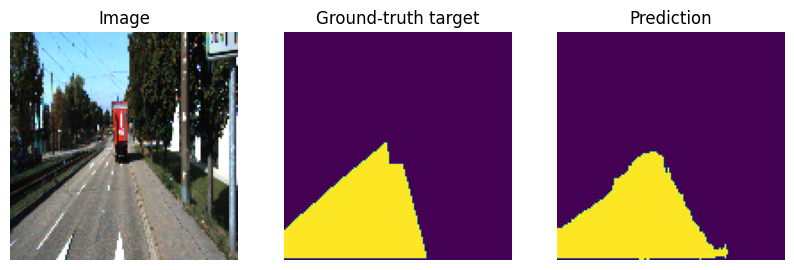

In [856]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(binary_predictions_2)

In [857]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(ground_truth_mask, binary_predictions_2)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.924331
